## Problema 2

Estamos interesados en aproximar la solución $u$ de la ecuación de Laplace con condición de borde Dirichlet, definida en un cuarto de anillo circular 

$$
\Omega := \{(x,y) \in \mathbb{R}^2 : x, y > 0, 1 < x^2 + y^2 < 4\}
$$

dada por

$$
\Delta u = 0 \quad \text{en } \Omega
$$

$$
u(x,0) = \ln(x), \quad x \in [1,2]
$$

$$
u(0,y) = \ln(y), \quad y \in [1,2]
$$

$$
u(x,y) = 0, \quad x, y > 0, \quad x^2 + y^2 = 1
$$

$$
u(x,y) = \ln(2), \quad x, y > 0, \quad x^2 + y^2 = 4
$$

### 2.1)
Primero, efectúe cambio a coordenadas polares, y exprese el problema en las nuevas variables.

### 2.2)
Describa el esquema de diferencias finitas a utilizar, indicando el sistema de ecuaciones a resolver. Expréselo en forma matricial.  
¿Bajo qué condiciones sobre $h > 0$ la matriz del sistema es monótona?

### 2.3)
Luego, implemente el esquema y testéelo para varias particiones, tabulando los errores en las normas $||\cdot||_p$, para $p \in \{2, \infty\}$ además de la llamada norma de energía $||\cdot||_h := h ||\cdot||_2$.  

Incluya los respectivos órdenes de convergencia experimentales (como en el ejemplo visto en clases). La solución exacta es:

$$
u(x,y) = \frac{1}{2} \ln(x^2 + y^2).
$$

Convergence Analysis Results:
+----+-----------------+-----------------+---------------+---------------+---------------+----------------+-----------------+-----------------+-----------------+
|    |              Nr |          Ntheta |             h |      L2 Error |    Linf Error |   Energy Error |         L2 Rate |       Linf Rate |     Energy Rate |
+====+=================+=================+===============+===============+===============+================+=================+=================+=================+
|  0 |   9.00000000000 |   9.00000000000 | 0.12500000000 | 0.00003914891 | 0.00007651278 |  0.00000489361 | nan             | nan             | nan             |
+----+-----------------+-----------------+---------------+---------------+---------------+----------------+-----------------+-----------------+-----------------+
|  1 |  17.00000000000 |  17.00000000000 | 0.06250000000 | 0.00001052465 | 0.00001932953 |  0.00000065779 |   2.03367828616 |   2.07677258653 |   3.07499181359 

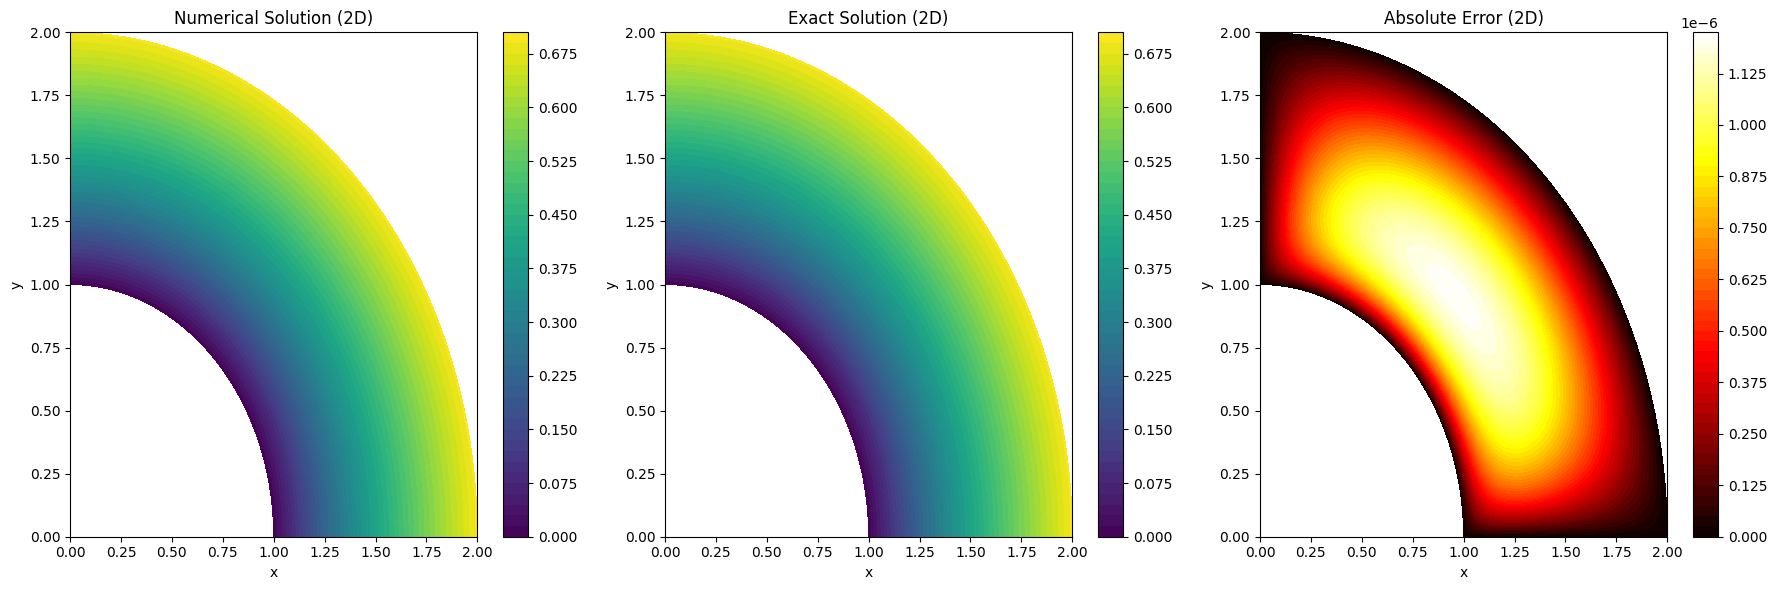

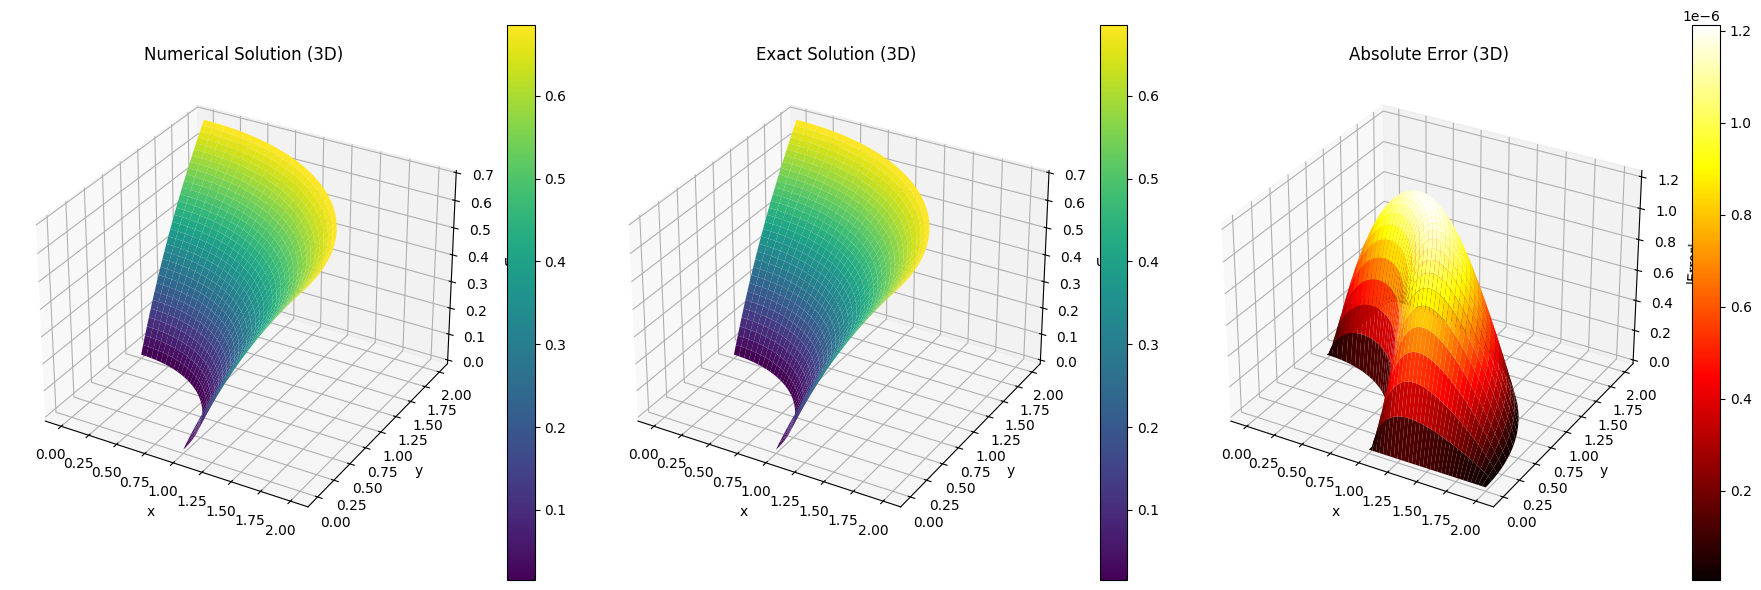

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import pandas as pd
from tabulate import tabulate


def setup_grid(Nr, Ntheta):
    """
    Set up the polar coordinate grid.

    Parameters:
    Nr: Number of points in radial direction
    Ntheta: Number of points in angular direction

    Returns:
    r_grid, theta_grid: 1D arrays of radial and angular coordinates
    hr, htheta: Grid spacing in radial and angular directions
    """
    # Domain: 1 < r < 2, 0 < theta < pi/2
    r_min, r_max = 1.0, 2.0
    theta_min, theta_max = 0.0, np.pi / 2

    # Create grid points
    r_grid = np.linspace(r_min, r_max, Nr)
    theta_grid = np.linspace(theta_min, theta_max, Ntheta)

    # Grid spacing
    hr = (r_max - r_min) / (Nr - 1)
    htheta = (theta_max - theta_min) / (Ntheta - 1)

    return r_grid, theta_grid, hr, htheta


def build_matrix_and_vector(Nr, Ntheta, r_grid, hr, htheta):
    """
    Build the finite difference matrix A and vector b.

    Parameters:
    Nr, Ntheta: Number of grid points in each direction
    r_grid: Radial grid points
    hr, htheta: Grid spacing

    Returns:
    A: Sparse coefficient matrix
    b: Right-hand side vector
    """
    # Number of interior points
    n_interior_r = Nr - 2
    n_interior_theta = Ntheta - 2
    n_total = n_interior_r * n_interior_theta

    # Create sparse matrix
    A = lil_matrix((n_total, n_total))
    b = np.zeros(n_total)

    # Coefficients calculation function
    def coefficients(r):
        a = htheta**2 * r**2 + (hr * htheta**2 * r) / 2  # u_{i+1,j}
        b_coef = htheta**2 * r**2 - (hr * htheta**2 * r) / 2  # u_{i-1,j}
        c = hr**2  # u_{i,j+1}
        d = hr**2  # u_{i,j-1}
        e = -2 * (htheta**2 * r**2 + hr**2)  # u_{i,j}
        return a, b_coef, c, d, e

    # Fill matrix A and vector b
    for i in range(1, Nr - 1):  # r-index for interior points
        for j in range(1, Ntheta - 1):  # theta-index for interior points
            row_idx = (i - 1) * n_interior_theta + (j - 1)
            r = r_grid[i]

            a, b_coef, c, d, e = coefficients(r)

            # Diagonal term (current point)
            A[row_idx, row_idx] = e

            # Connections in r-direction
            if i < Nr - 2:  # Not the last interior point in r
                A[row_idx, row_idx + n_interior_theta] = a
            else:  # Last interior point, boundary at r=2
                b[row_idx] -= a * np.log(2)

            if i > 1:  # Not the first interior point in r
                A[row_idx, row_idx - n_interior_theta] = b_coef
            else:  # First interior point, boundary at r=1
                b[row_idx] -= b_coef * 0  # u=0 at r=1

            # Connections in theta-direction
            if j < Ntheta - 2:  # Not the last interior point in theta
                A[row_idx, row_idx + 1] = c
            else:  # Last interior point, boundary at theta=pi/2
                b[row_idx] -= c * np.log(r)

            if j > 1:  # Not the first interior point in theta
                A[row_idx, row_idx - 1] = d
            else:  # First interior point, boundary at theta=0
                b[row_idx] -= d * np.log(r)

    return csr_matrix(A), b


def solve_laplace(Nr, Ntheta):
    """
    Solve the Laplace equation with the given grid sizes.

    Parameters:
    Nr, Ntheta: Number of grid points in each direction

    Returns:
    u_numerical: Numerical solution
    u_exact: Exact solution
    r_grid, theta_grid: Grid points
    hr, htheta: Grid spacing
    """
    # Setup grid
    r_grid, theta_grid, hr, htheta = setup_grid(Nr, Ntheta)

    # Build matrix and right-hand side vector
    A, b = build_matrix_and_vector(Nr, Ntheta, r_grid, hr, htheta)

    # Solve the linear system
    u_interior = spsolve(-A, -b)

    # Reshape solution to 2D grid (including boundaries)
    u_numerical = np.zeros((Nr, Ntheta))

    # Fill interior points
    for i in range(1, Nr - 1):
        for j in range(1, Ntheta - 1):
            idx = (i - 1) * (Ntheta - 2) + (j - 1)
            u_numerical[i, j] = u_interior[idx]

    # Fill boundary points
    u_numerical[0, :] = 0  # r=1
    u_numerical[Nr - 1, :] = np.log(2)  # r=2
    u_numerical[1 : Nr - 1, 0] = np.log(r_grid[1 : Nr - 1])  # theta=0
    u_numerical[1 : Nr - 1, Ntheta - 1] = np.log(r_grid[1 : Nr - 1])  # theta=pi/2

    # Exact solution
    u_exact = np.zeros((Nr, Ntheta))
    for i in range(Nr):
        for j in range(Ntheta):
            r = r_grid[i]
            theta = theta_grid[j]
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            u_exact[i, j] = 0.5 * np.log(x**2 + y**2)

    return u_numerical, u_exact, r_grid, theta_grid, hr, htheta


def calculate_errors(u_numerical, u_exact, hr, htheta):
    """
    Calculate errors in different norms.

    Parameters:
    u_numerical, u_exact: Numerical and exact solutions
    hr, htheta: Grid spacing

    Returns:
    error_2, error_inf, error_energy: Errors in 2-norm, infinity-norm, and energy norm
    """
    # Calculate the difference
    error = u_numerical - u_exact

    # L2 norm
    error_2 = np.sqrt(np.sum(error**2) / error.size)

    # L-infinity norm
    error_inf = np.max(np.abs(error))

    # Energy norm (h*L2-norm)
    h = hr  # Grid size in radial direction, as per the problem statement
    error_energy = h * error_2

    return error_2, error_inf, error_energy


def calculate_convergence_rates(n_values, errors):
    """
    Calculate experimental convergence rates.

    Parameters:
    n_values: List of grid sizes
    errors: List of errors for each grid size

    Returns:
    rates: Convergence rates
    """
    h_values = 1.0 / np.array(n_values)
    rates = [np.nan]

    for i in range(0, len(errors) - 1):
        rate = np.log(errors[i - 1] / errors[i]) / np.log(h_values[i - 1] / h_values[i])
        rates.append(rate)

    return rates  # Add NaN for the last row


def plot_solution(r_grid, theta_grid, u_numerical, u_exact):
    """
    Plot numerical and exact solutions in 2D and 3D.

    Parameters:
    r_grid, theta_grid: Grid points
    u_numerical, u_exact: Numerical and exact solutions
    """
    # Convert to Cartesian for plotting
    R, THETA = np.meshgrid(r_grid, theta_grid, indexing="ij")
    X = R * np.cos(THETA)
    Y = R * np.sin(THETA)

    # 2D Plots
    fig2d, axs2d = plt.subplots(1, 3, figsize=(18, 6))
    contour1 = axs2d[0].contourf(X, Y, u_numerical, 50, cmap="viridis")
    axs2d[0].set_title("Numerical Solution (2D)")
    axs2d[0].set_xlabel("x")
    axs2d[0].set_ylabel("y")
    plt.colorbar(contour1, ax=axs2d[0])

    contour2 = axs2d[1].contourf(X, Y, u_exact, 50, cmap="viridis")
    axs2d[1].set_title("Exact Solution (2D)")
    axs2d[1].set_xlabel("x")
    axs2d[1].set_ylabel("y")
    plt.colorbar(contour2, ax=axs2d[1])

    contour3 = axs2d[2].contourf(X, Y, np.abs(u_numerical - u_exact), 50, cmap="hot")
    axs2d[2].set_title("Absolute Error (2D)")
    axs2d[2].set_xlabel("x")
    axs2d[2].set_ylabel("y")
    plt.colorbar(contour3, ax=axs2d[2])

    plt.tight_layout()
    plt.savefig("results_2d.png")

    # 3D Plots
    fig3d = plt.figure(figsize=(18, 6))

    ax1 = fig3d.add_subplot(131, projection="3d")
    surf1 = ax1.plot_surface(X, Y, u_numerical, cmap="viridis")
    ax1.set_title("Numerical Solution (3D)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("u")
    plt.colorbar(surf1, ax=ax1)

    ax2 = fig3d.add_subplot(132, projection="3d")
    surf2 = ax2.plot_surface(X, Y, u_exact, cmap="viridis")
    ax2.set_title("Exact Solution (3D)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u")
    plt.colorbar(surf2, ax=ax2)

    ax3 = fig3d.add_subplot(133, projection="3d")
    surf3 = ax3.plot_surface(X, Y, np.abs(u_numerical - u_exact), cmap="hot")
    ax3.set_title("Absolute Error (3D)")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("|Error|")
    plt.colorbar(surf3, ax=ax3)

    plt.tight_layout()
    plt.savefig("results_3d.png")
    plt.show()


def run_convergence_analysis():
    """
    Run convergence analysis for different grid sizes.
    """
    grid_sizes = [9, 17, 33, 65, 129]
    results = []

    for n in grid_sizes:
        Nr = Ntheta = n
        u_numerical, u_exact, r_grid, theta_grid, hr, htheta = solve_laplace(Nr, Ntheta)
        error_2, error_inf, error_energy = calculate_errors(
            u_numerical, u_exact, hr, htheta
        )
        results.append(
            {
                "Nr": Nr,
                "Ntheta": Ntheta,
                "h": hr,
                "L2 Error": error_2,
                "Linf Error": error_inf,
                "Energy Error": error_energy,
            }
        )

    df = pd.DataFrame(results)
    l2_rates = calculate_convergence_rates(grid_sizes, df["L2 Error"].values)
    linf_rates = calculate_convergence_rates(grid_sizes, df["Linf Error"].values)
    energy_rates = calculate_convergence_rates(grid_sizes, df["Energy Error"].values)

    df["L2 Rate"] = l2_rates
    df["Linf Rate"] = linf_rates
    df["Energy Rate"] = energy_rates

    return df


def main():
    result_df = run_convergence_analysis()
    print("Convergence Analysis Results:")
    print(tabulate(result_df, headers="keys", tablefmt="grid", floatfmt=".11f"))
    with open("results_table.tex", "w") as f:
        f.write(result_df.to_latex(index=False, float_format="%.11f"))
    Nr = Ntheta = 65
    u_numerical, u_exact, r_grid, theta_grid, hr, htheta = solve_laplace(Nr, Ntheta)
    plot_solution(r_grid, theta_grid, u_numerical, u_exact)


if __name__ == "__main__":
    main()
